In [185]:
import sys
sys.path.append("../")
import pickle
import numpy as np
import matplotlib.pyplot as plt
from src.visualization.visualize import plot_events, plot_data
import torch

In [138]:
with open('../data/raw/pois/train.pkl', 'rb') as f:
    data_train = pickle.load(f)

In [139]:
with open('../data/raw/pois/test.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [140]:
data_train[0].keys()

dict_keys(['start', 'stop', 'time_context', 'mark_context', 'time_target', 'mark_target', 'lambda_x', 't_x', 'id'])

In [141]:
for i in range(3):
    test = []
    train = []
    for j in range(10):
        train.append(np.unique(data_train[i*10 + j]['lambda_x'], return_counts=True)[1])
        test.append(np.unique(data_test[i*10 + j]['lambda_x'], return_counts=True)[1])
        # print('train', np.unique(data_train[i]['lambda_x'], return_counts=True))
        # print('test', np.unique(data_test[i]['lambda_x'], return_counts=True))
    print('test:', np.mean(test, axis=0), 'train:', np.mean(train, axis=0))

test: [613.2 385.8] train: [614.5 384.5]
test: [486.5 512.5] train: [467.8 531.2]
test: [555.7 443.3] train: [569.3 429.7]


In [142]:
with open('../data/raw/pois/param.pkl', 'rb') as f:
    params = pickle.load(f)

In [143]:
max_distance = 0
max_indices = (0, 0)

# Iterate over each pair of vectors
for i in range(len(params)):
    for j in range(i+1, len(params)):
        distance = np.sum(np.abs(params[i] - params[j]))
        if distance > max_distance:
            max_distance = distance
            max_indices = (i, j)

max_indices, max_distance

((8, 11), 0.9789276277046852)

In [144]:
first_example = None
second_example = None
for seq in data_train:
    if seq['id'] == max_indices[0] and first_example is None:
        first_example = seq
    elif seq['id'] == max_indices[1] and second_example is None:
        second_example = seq

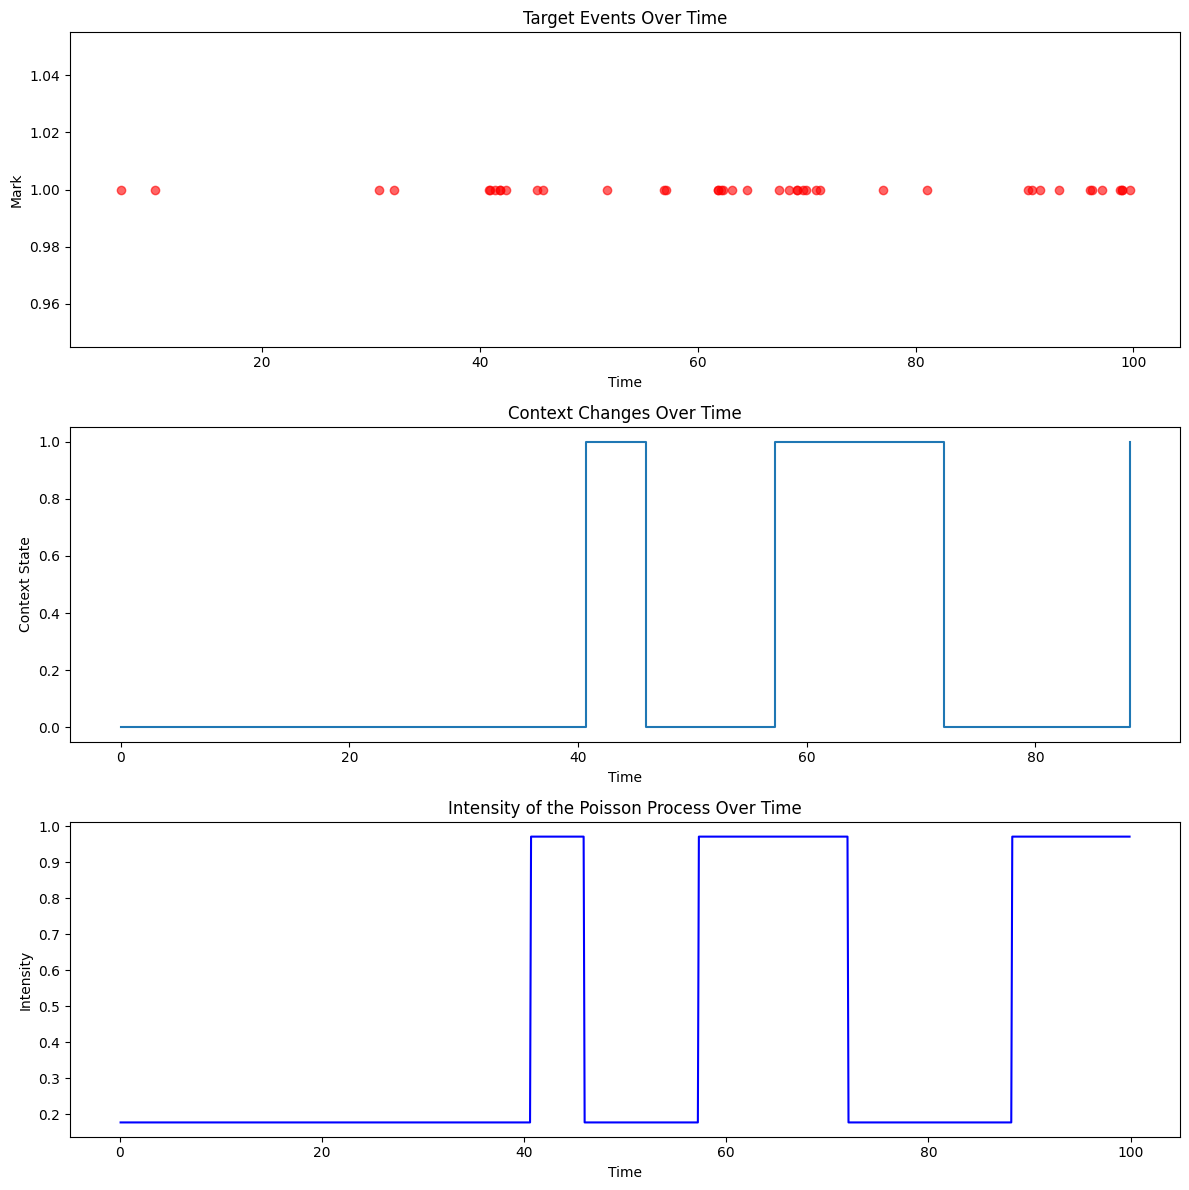

In [145]:
plot_data(first_example)

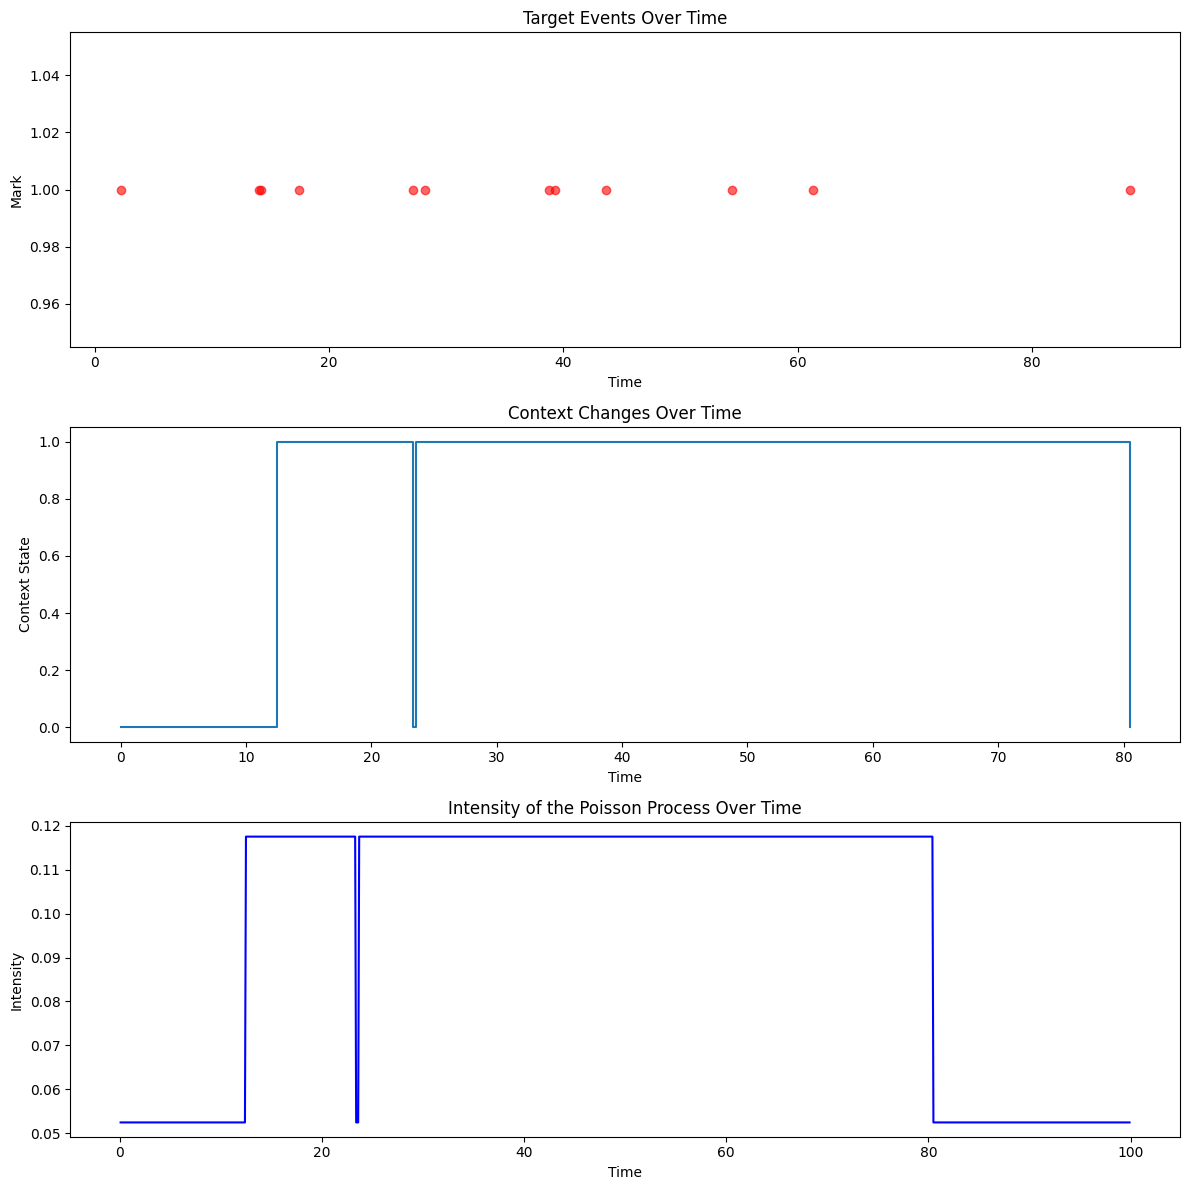

In [146]:
plot_data(second_example)

# Train Data

In [177]:
from src.data.dataloader import get_cppod_dataloader

In [178]:
gen_non_context = get_cppod_dataloader(data_train, 1, 1, False)
gen_context = get_cppod_dataloader(data_train, 1, 1, True)

In [183]:
def plot_data_model(label_seq, time_seq):
    plt.figure(figsize=(12, 6))
    
    # Define a list of distinct colors
    distinct_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    unique_labels = torch.unique(label_seq)
    for idx, lbl in enumerate(unique_labels):
        color = distinct_colors[idx % len(distinct_colors)]  # Cycle through distinct_colors
        mask = label_seq == lbl
        plt.scatter(time_seq[mask], [1]*torch.sum(mask), label=f'Label {lbl}', color=color, marker='o', alpha=0.6)
        
    plt.xlabel('Time')
    plt.yticks([])  # Hide y-axis ticks
    plt.title('Event Data: Label vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

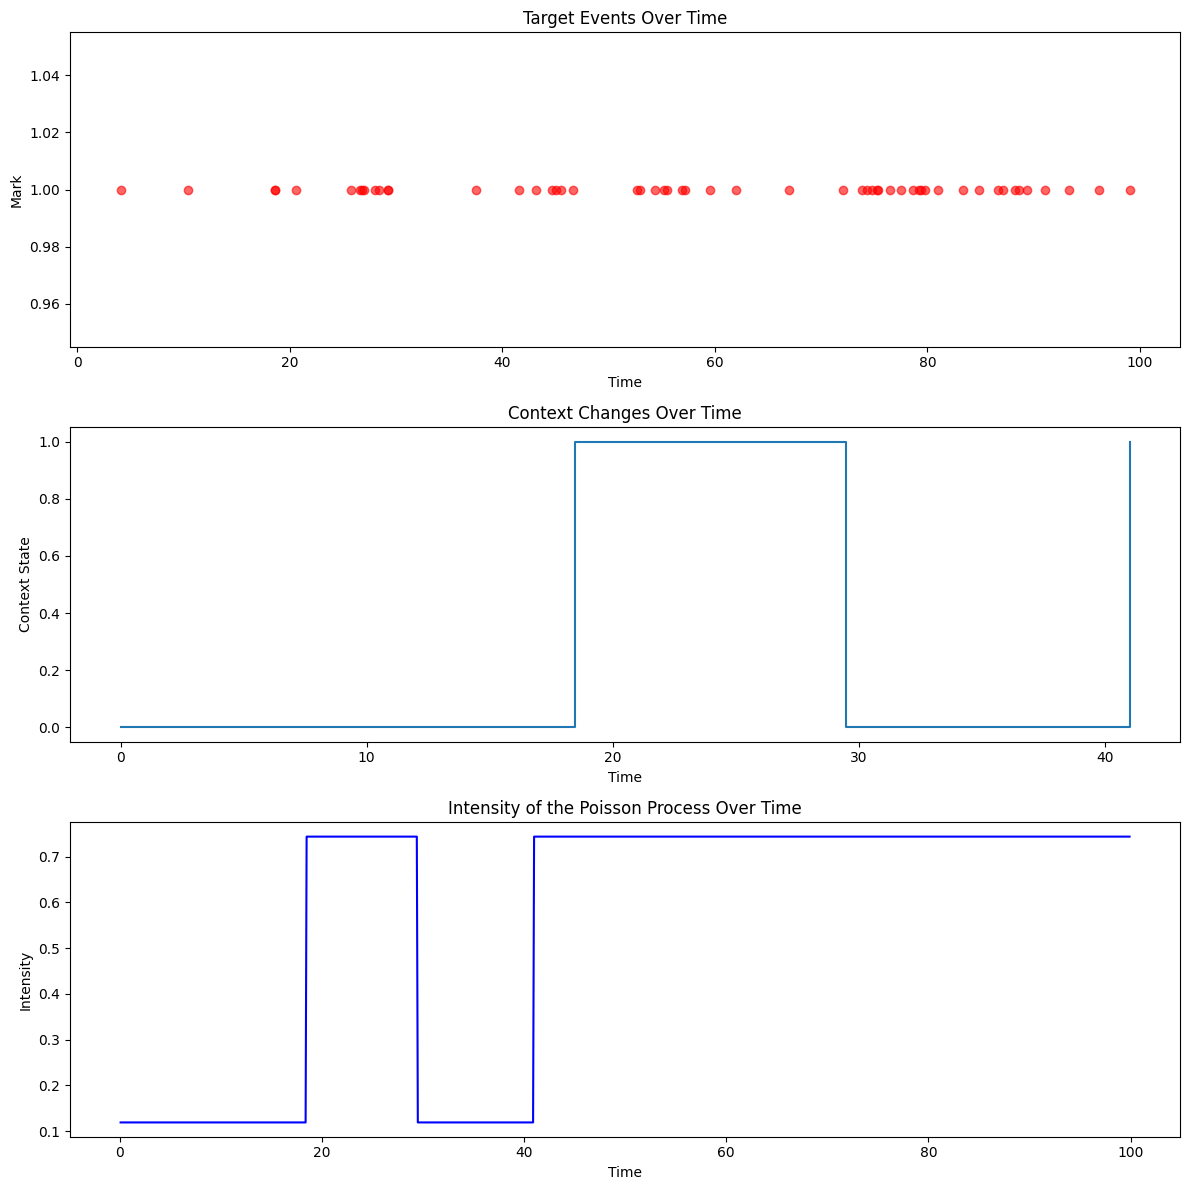

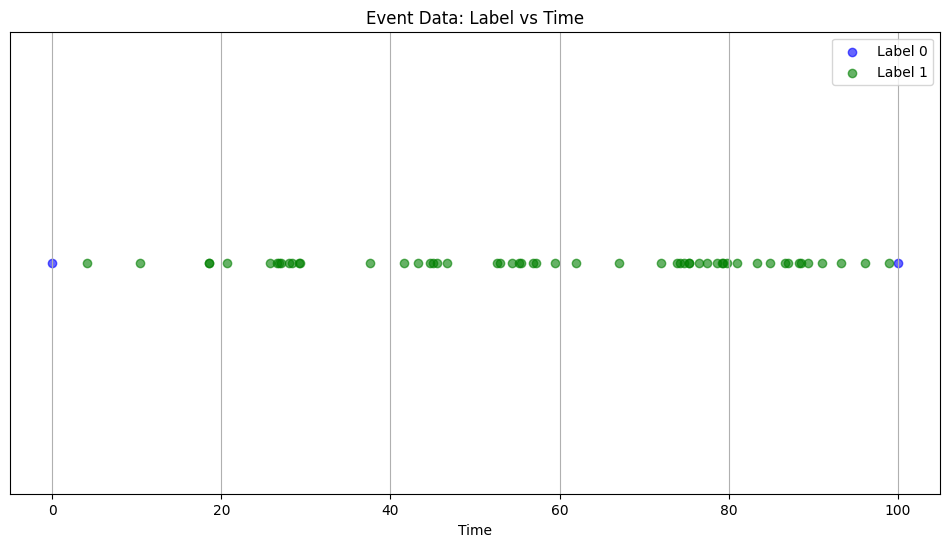

In [189]:
for i in gen_non_context:
    plot_data(data_train[0])
    plot_data_model(i[0]['label_seq'], i[0]['time_seq'])
    break

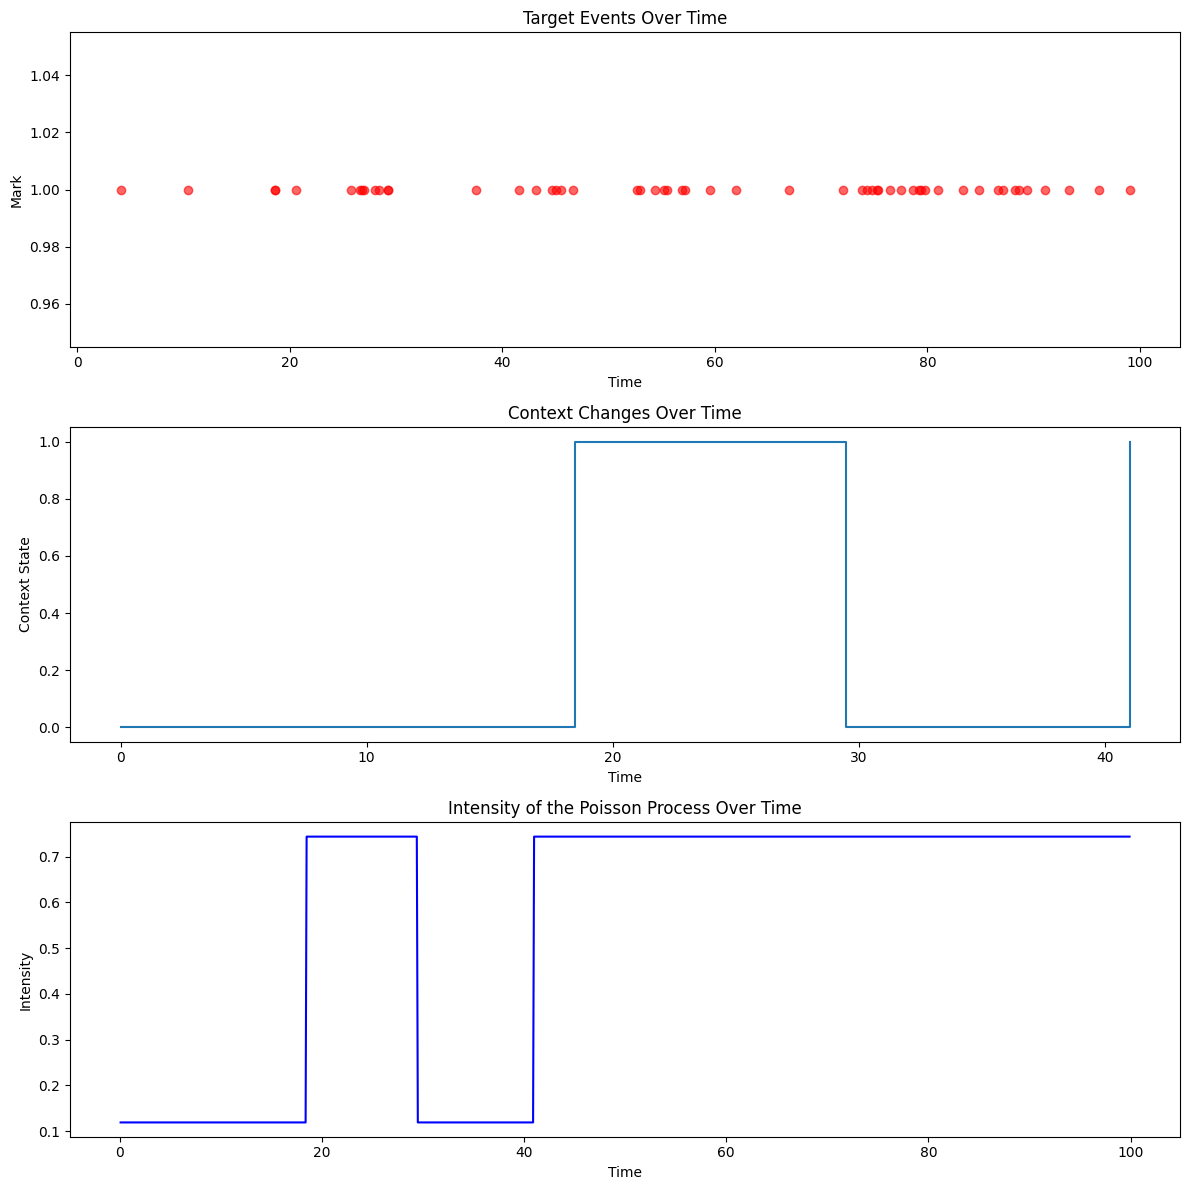

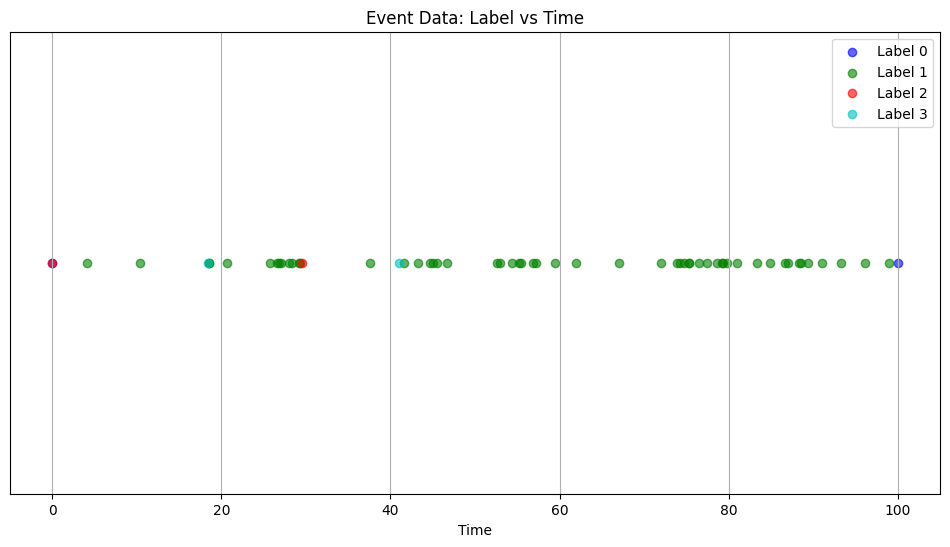

In [190]:
for i in gen_context:
    plot_data(data_train[0])
    plot_data_model(i[0]['label_seq'], i[0]['time_seq'])
    break

In [4]:
files = ['test.pkl', 
         'test_commiss_0.1.pkl',
         'test_commiss_pc.pkl',
         'test_commiss_sin.pkl',
         'test_omiss_0.1.pkl',
         'test_omiss_pc.pkl',
         'test_omiss_sin.pkl',
         ]

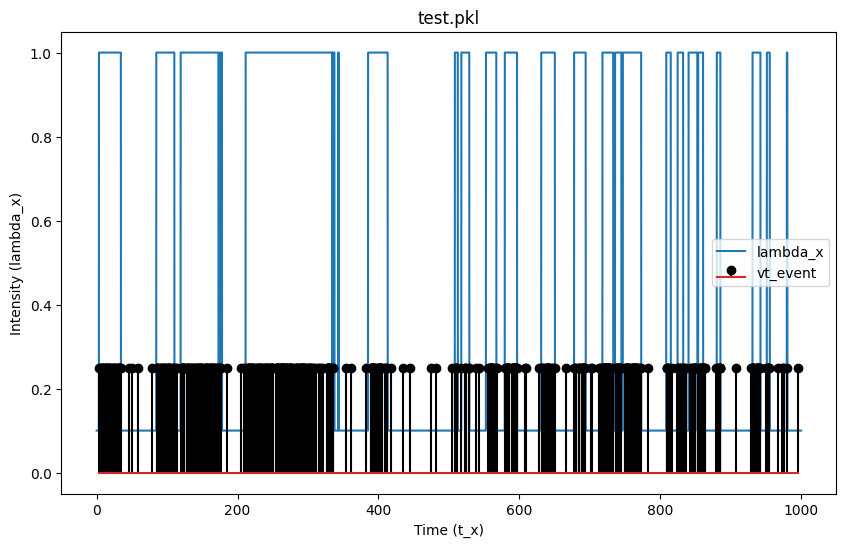

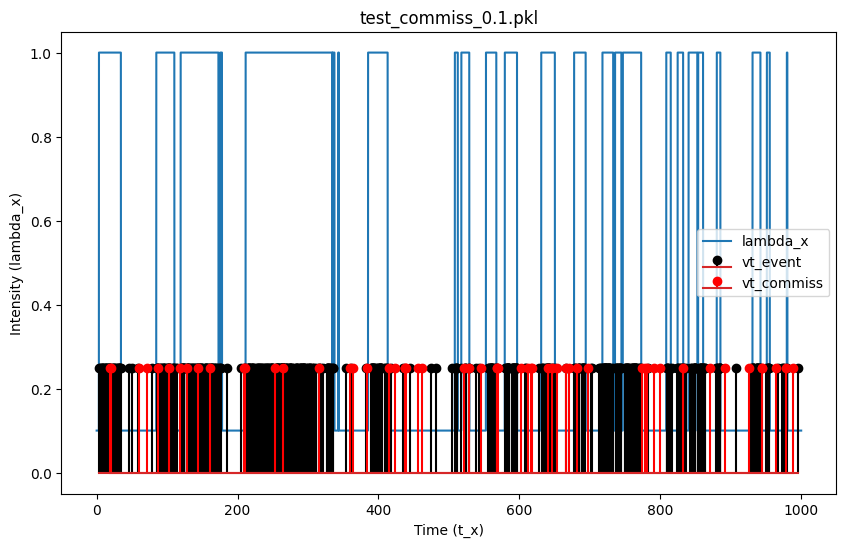

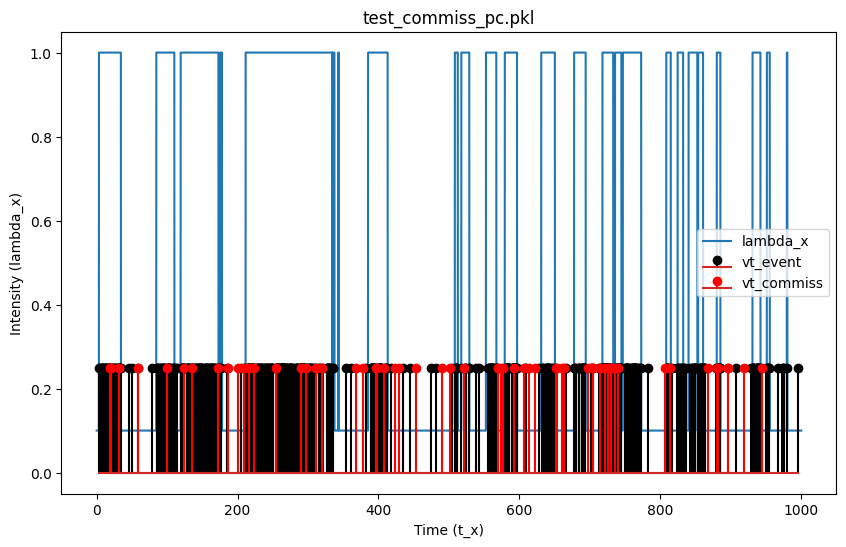

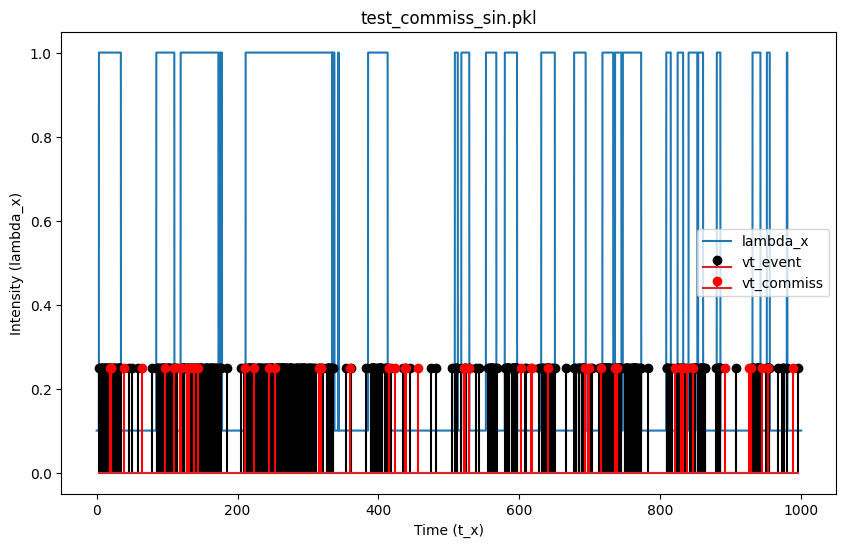

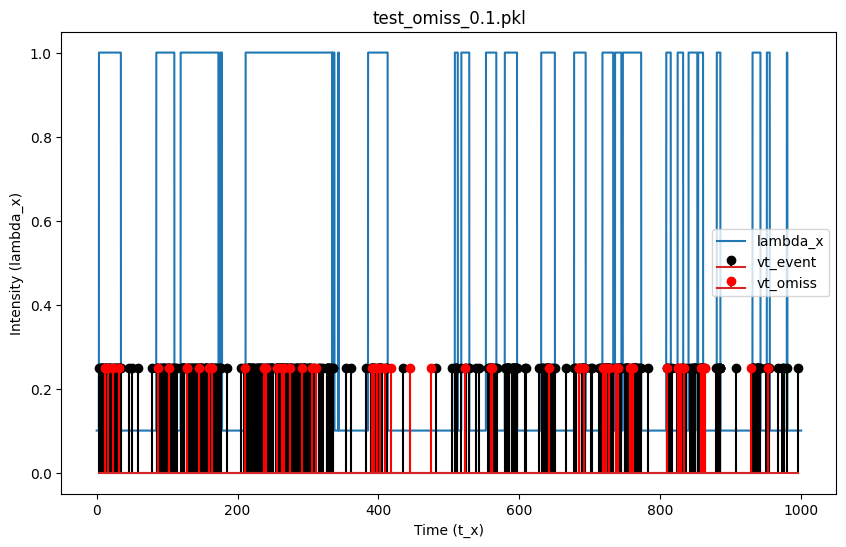

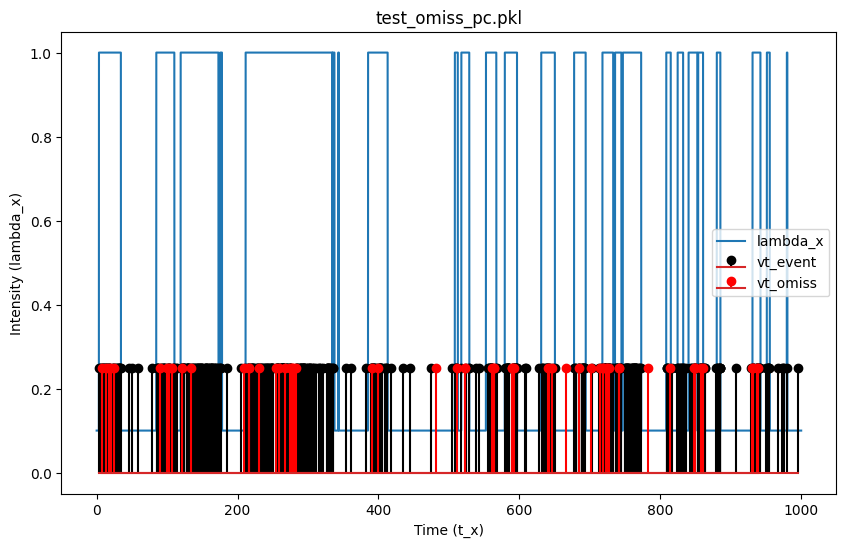

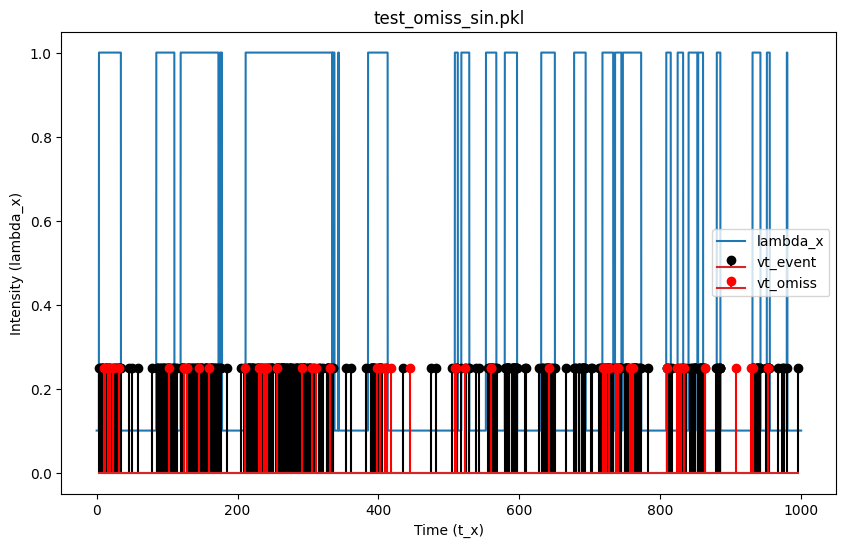

In [5]:
for file in files:
    with open(f'../data/raw/pois/{file}', 'rb') as f:
        data_train = pickle.load(f)    
        plot_events(data_train[0], title=file)
        plt.show()

# Predict

In [6]:
from sklearn.metrics import roc_curve

def find_best_threshold_euclidean(y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Compute squared distance from ROC curve to point (0,1)
    distance_squared = (fpr**2) + ((tpr - 1)**2)
    
    # Find index of minimum distance
    idx = np.argmin(distance_squared)
    
    # Return the optimal threshold
    return thresholds[idx]

In [19]:
outliers_type = ['commiss', 'omiss']


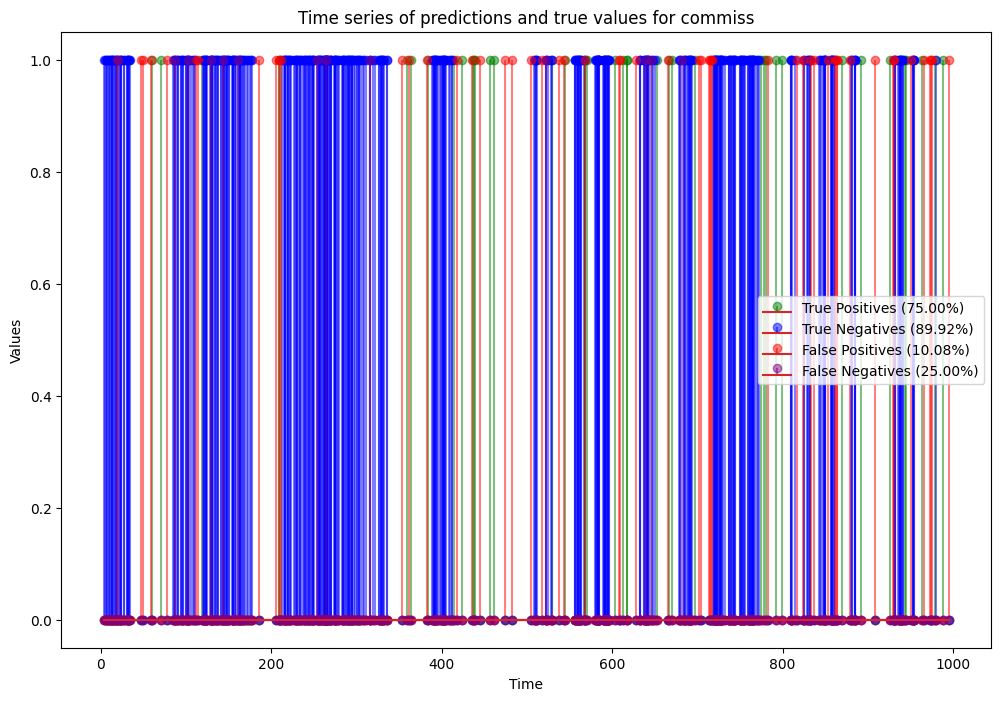

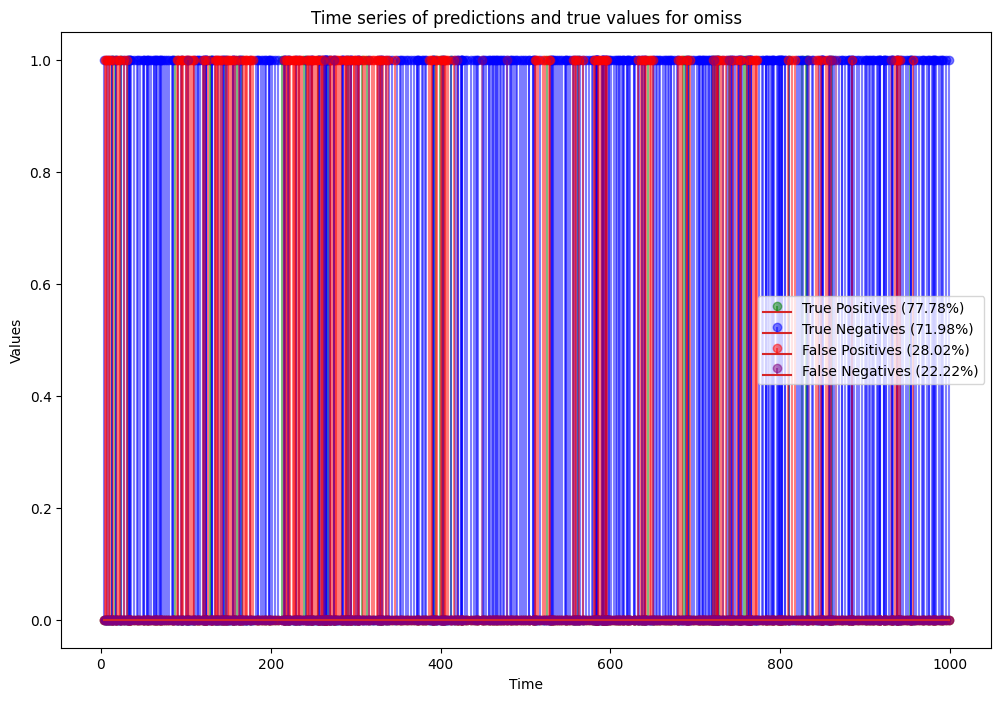

In [42]:
import pandas as pd
for outlier in outliers_type:
    df = pd.read_csv(f'../results/pois/{outlier}/CPPOD_0.1.csv', index_col=0)
    df['label'] = df['label'].astype(int)
    best_thresh = find_best_threshold_euclidean(y_true=df['label'], y_scores=df[f'score_{outlier}'])
    df = df[df.seq.eq(0)]
    predict_label = lambda x: 0 if x < best_thresh else 1
    df['prediction'] = df[f'score_{outlier}'].apply(predict_label)

    df['TP'] = ((df['prediction'] == 1) & (df['label'] == 1)).astype(int)
    df['TN'] = ((df['prediction'] == 0) & (df['label'] == 0)).astype(int)
    df['FP'] = ((df['prediction'] == 1) & (df['label'] == 0)).astype(int)
    df['FN'] = ((df['prediction'] == 0) & (df['label'] == 1)).astype(int)

    total_positives = df['label'].sum()
    total_negatives = len(df) - total_positives

    # Compute the percentages
    TP_percent = df['TP'].sum() / total_positives * 100
    FN_percent = df['FN'].sum() / total_positives * 100
    TN_percent = df['TN'].sum() / total_negatives * 100
    FP_percent = df['FP'].sum() / total_negatives * 100


    # Plotting
    plt.figure(figsize=(12, 8))

    markerline, stemlines, baseline = plt.stem(df['time'], df['TP'], linefmt='-', markerfmt='o', label=f'True Positives ({TP_percent:.2f}%)')
    plt.setp(markerline, 'color', 'green', alpha=0.5)
    plt.setp(stemlines, 'color', 'green', alpha=0.5)

    markerline, stemlines, baseline = plt.stem(df['time'], df['TN'], linefmt='-', markerfmt='o', label=f'True Negatives ({TN_percent:.2f}%)')
    plt.setp(markerline, 'color', 'blue', alpha=0.5)
    plt.setp(stemlines, 'color', 'blue', alpha=0.5)

    markerline, stemlines, baseline = plt.stem(df['time'], df['FP'], linefmt='-', markerfmt='o', label=f'False Positives ({FP_percent:.2f}%)')
    plt.setp(markerline, 'color', 'red', alpha=0.5)
    plt.setp(stemlines, 'color', 'red', alpha=0.5)

    markerline, stemlines, baseline = plt.stem(df['time'], df['FN'], linefmt='-', markerfmt='o', label=f'False Negatives ({FN_percent:.2f}%)')
    plt.setp(markerline, 'color', 'purple', alpha=0.5)
    plt.setp(stemlines, 'color', 'purple', alpha=0.5)

    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'Time series of predictions and true values for {outlier}')
    plt.legend(loc='best')

    plt.show()